# Solving SIR model with PINN

In [17]:
import torch
import sys
import numpy as np
import matplotlib.pyplot as plt
from kan import KAN

# Set the seed for reproducibility
torch.manual_seed(42)

# Add the parent directory of the script (i.e., project/) to sys.path
sys.path.append('../../utils')
from upinn import UPINN
from architectures import FNN, ResNet
from SIRData import SIRData, CyclicSIRData
from utils import SINDy_sklearn, sample_collocation_points

## Generate Data from System

In [18]:
beta = 0.3
gamma = 1/21
theta = 1/90

X0 = torch.tensor([0.9999, 0.0001, 0.00])

In [34]:
time_int = [0, 60]
Nd = time_int[1]

# time_points = np.linspace(time_int[0], time_int[1], Nd+1, endpoint=True)[1:]
time_points = np.arange(time_int[0], time_int[1], 7)[1:]

# data = SIRData(X0, beta1, beta2, gamma1, gamma2, time_int, N=1000, time_points=time_points)
data = CyclicSIRData(X0, beta, gamma, theta, time_int, N=1000, time_points=time_points, noise_level=0.0)
td = data.td
Xd = data.Xd

In [20]:
# Boundary conditions
tbc = torch.tensor([[0.0]])
Xbc = X0.reshape(-1, 3)

In [21]:
# Collocation points
N_coll = 1000
tc = sample_collocation_points(N_coll, 1, lb=[time_int[0]], ub=[time_int[1]], method='grid')

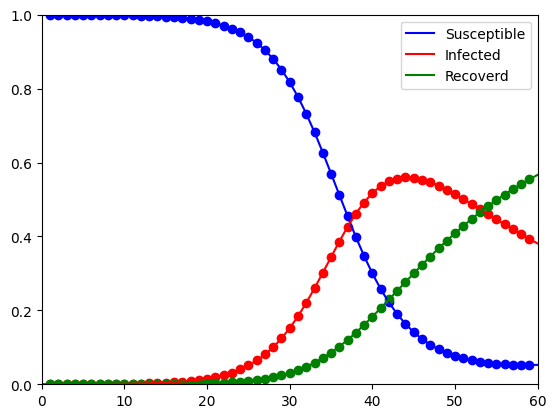

In [22]:
plt.plot(data.t_full, data.X_full[:,0], label='Susceptible', color='blue')
plt.plot(data.t_full, data.X_full[:,1], label='Infected', color='red')
plt.plot(data.t_full, data.X_full[:,2], label='Recoverd', color='green')
plt.scatter(td, data.Xd[:,0], color='blue')
plt.scatter(td, data.Xd[:,1], color='red')
plt.scatter(td, data.Xd[:,2], color='green')
plt.xlim(data.t_full[0], data.t_full[-1])
plt.ylim(0,1)
plt.legend()
plt.show()

### Known system $N_K$

In [23]:
class SIR(torch.nn.Module):
    
    def __init__(self, params):
        super(SIR, self).__init__()
        
        # Set the parameters
        for key, value in params.items():
            setattr(self, key, value) 

    def forward(self, z, U):

        lhs = torch.cat([
        torch.autograd.grad(outputs=U[:, i], inputs=z, grad_outputs=torch.ones_like(U[:, i]), create_graph=True)[0]
        for i in range(U.shape[1])
        ], dim=-1)

        # rhs = torch.stack([
        #     - self.beta1 * U[:, 0] * U[:, 1] - self.beta2 * U[:, 0] * U[:, 2],
        #     self.beta1 * U[:, 0] * U[:, 1] - self.gamma1 * U[:, 1],
        #     self.beta2 * U[:, 0] * U[:, 2] - self.gamma2 * U[:, 2],
        #     self.gamma1 * U[:, 1] + self.gamma2 * U[:, 1]
        # ], dim=-1)

        # S = U[:, 0]
        # I1 = U[:, 1]
        # I2 = U[:, 2]
        # R = U[:, 3]

        # rhs = torch.stack([
        #     -self.beta1*S*I1,
        #     self.beta1*S*I1 - self.gamma1*I1,
        #     -self.gamma2*I2,
        #     self.gamma1*I1 + self.gamma2*I2
        # ], dim=-1)

        S = U[:, 0]
        I = U[:, 1]
        R = U[:, 2]

        rhs = torch.stack([
            -self.beta*S*I,
            self.beta*S*I - self.gamma*I,
            self.gamma*I
        ], dim=-1)

        norm = torch.maximum(torch.abs(lhs), torch.abs(rhs)) + 1e-6

        return lhs - rhs


params = dict(
    beta=beta,
    gamma=gamma,
    theta=theta
)

N = SIR(params)

### Problem specific UPINN functions

In [24]:
phi = torch.nn.Parameter(torch.tensor(0.0))

class SIR_UPINN(UPINN):

    def score(self):
        u_pred = self.u(data.t_full)
        return torch.sqrt(torch.mean((u_pred - data.X_full)**2) / torch.mean(data.X_full**2))
    
    def F_input(self, z, U):
        return U
    

    def data_loss(self):
        u_pred = self.u(self.data_points[0])
        return torch.mean((u_pred[:, 1] - self.data_points[1][:, 1])**2)
    
    # def pde_loss(self):
    #     u_pred = self.u(self.collocation_points)
    #     known = self.N(self.collocation_points, u_pred)
    #     unknown = self.F(self.F_input(self.collocation_points, u_pred))
        
    # #     # res = torch.cat([-unknown[:, 0:1]+unknown[:, 2:3], unknown[:, 0:1]-unknown[:, 1:2], unknown[:, 1:2]-unknown[:, 2:3]], dim=-1)
    # #     # res = torch.cat([unknown[:, 2:3], 0*unknown[:, 1:2], -unknown[:, 2:3]], dim=-1)

    #     return torch.nn.MSELoss()(known, -unknown) + 1e-3*torch.mean(unknown**2)



    def plot(self, save=None):
        
        self.to('cpu')

        with torch.no_grad():
            # Get network predictions
            u_pred = self.u(data.t_full)

            plt.plot(data.t_full, data.X_full[:,0], label='S', linestyle='--', color='b')
            plt.plot(data.t_full, data.X_full[:,1], label='I', linestyle='--', color='y')
            plt.plot(data.t_full, data.X_full[:,2], label='R', linestyle='--', color='g')
            # plt.plot(data.t_full, data.X_full[:,3], label='R', linestyle='--', color='r')
            plt.plot(data.t_full, u_pred[:,0].numpy(), color='b')
            plt.plot(data.t_full, u_pred[:,1].numpy(), color='y')
            plt.plot(data.t_full, u_pred[:,2].numpy(), color='g')
            # plt.plot(data.t_full, u_pred[:,3].numpy(), color='r')
            plt.legend()
            plt.show()



### Setup UPINN

In [25]:
class SIRNet(FNN):
    def forward(self, z):
        z = (z - td.min()) / (td.max() - td.min())
        z = super().forward(z)
        # z = torch.nn.functional.softplus(z)
        return z / torch.sum(z, dim=1, keepdim=True)

# class SIRResidual(FNN):
#     def forward(self, z):
#         z = super().forward(z)
#         # Apply softplus to first and last component
#         z = torch.cat([torch.nn.functional.softplus(z[:,0:1]), torch.zeros_like(z[:,1:2]), z[:,1:2], -torch.nn.functional.softplus(z[:,-1:])], dim=1)
#         return z

class SIRResidual(FNN):
    def forward(self, z):
        z = super().forward(z)
        z = torch.cat([z[:,0:1]-z[:,1:2], z[:,1:2]-z[:,2:3], z[:,2:3]-z[:,0:1]], dim=1)
        return z



In [26]:
# Define model architectures
hidden = [16] * 3
u = SIRNet(
    dims=[1, *hidden, 3],
    hidden_act=torch.nn.Tanh(),
    output_act=torch.nn.Softmax(),
)

hiddenF = [16] * 3
F = FNN(
    dims=[3, *hiddenF, 3],
    hidden_act=torch.nn.Tanh(),
)
# F = SIRResidual(
#     dims=[3, *hiddenF, 3],
#     hidden_act=torch.nn.Tanh(),
# )

# u = KAN([1, 3, 3], grid=5)
# F = KAN([3, 3, 3], grid=5)

In [27]:
model = SIR_UPINN(u, N, F, boundary_points=(tbc, Xbc), data_points=(td, Xd), collocation_points=tc)
# model = SIR_UPINN(u, N, F, data_points=(td, Xd), collocation_points=tc)
# model = SIR_UPINN(u, N, F, boundary_points=(tbc, Xbc), collocation_points=tc)
# model.set_dark()

[Info]: Initializing UPINN model


### Train

In [28]:
adamw = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
model.optimizer = adamw

In [29]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(adamw, factor=0.5, patience=500, threshold=1e-3)
model.scheduler = scheduler

In [30]:
scheduler.get_last_lr()

[0.001]

[Info]: Training 1000 epoch(s) on cpu using AdamW optimizer.


[CPU]: 100%|██████████| 1000/1000 [00:14<00:00, 67.55 epoch/s, bc_loss=3.75e-06, data_loss=5.49e-06, pde_loss=9.52e-06, loss=1.88e-05]


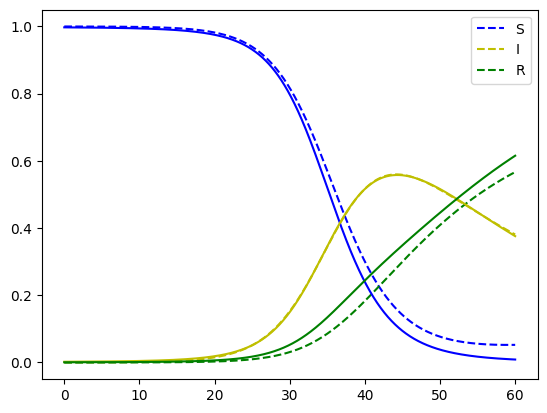

[Info]: Training 1000 epoch(s) on cpu using AdamW optimizer.


[CPU]: 100%|██████████| 1000/1000 [00:15<00:00, 65.61 epoch/s, bc_loss=2.49e-06, data_loss=3.60e-06, pde_loss=5.47e-06, loss=1.16e-05]


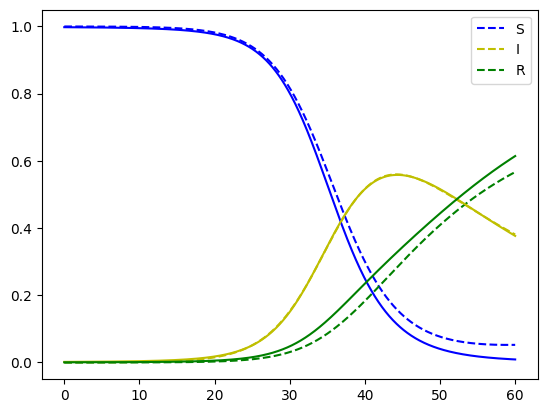

[Info]: Training 1000 epoch(s) on cpu using AdamW optimizer.


[CPU]: 100%|██████████| 1000/1000 [00:13<00:00, 75.07 epoch/s, bc_loss=1.52e-06, data_loss=1.92e-06, pde_loss=2.46e-06, loss=5.90e-06]


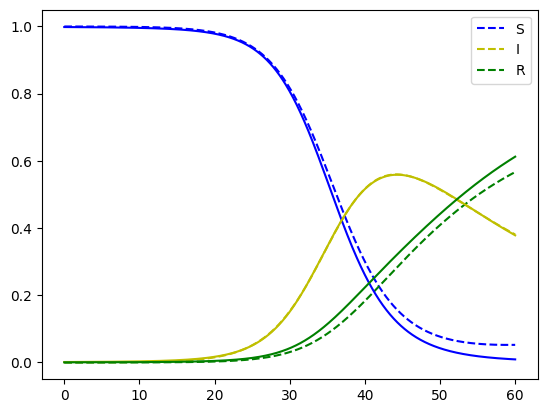

[Info]: Training 1000 epoch(s) on cpu using AdamW optimizer.


[CPU]: 100%|██████████| 1000/1000 [00:14<00:00, 68.50 epoch/s, bc_loss=9.15e-07, data_loss=8.58e-07, pde_loss=8.40e-07, loss=2.61e-06]


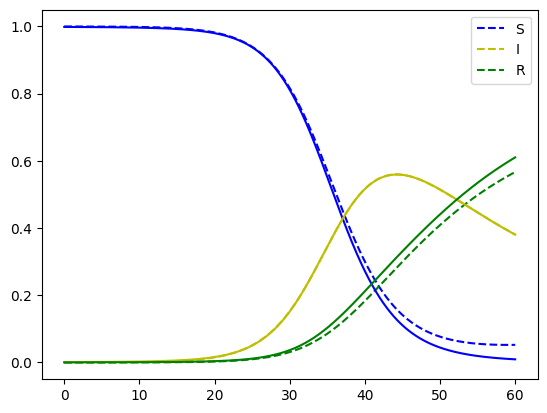

[Info]: Training 1000 epoch(s) on cpu using AdamW optimizer.


[CPU]: 100%|██████████| 1000/1000 [00:14<00:00, 68.91 epoch/s, bc_loss=5.54e-07, data_loss=4.00e-07, pde_loss=2.92e-07, loss=1.25e-06]


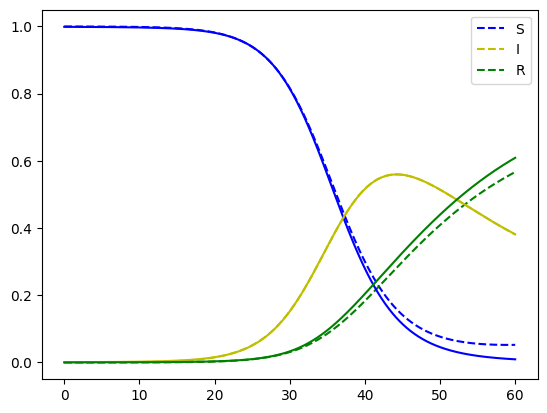

[Info]: Training 1000 epoch(s) on cpu using AdamW optimizer.


[CPU]: 100%|██████████| 1000/1000 [00:13<00:00, 74.70 epoch/s, bc_loss=3.57e-07, data_loss=2.29e-07, pde_loss=1.26e-07, loss=7.12e-07]


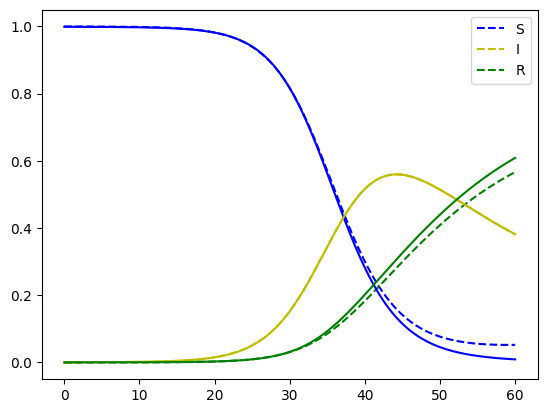

[Info]: Training 1000 epoch(s) on cpu using AdamW optimizer.


[CPU]: 100%|██████████| 1000/1000 [00:13<00:00, 75.69 epoch/s, bc_loss=2.45e-07, data_loss=1.45e-07, pde_loss=6.40e-08, loss=4.53e-07]


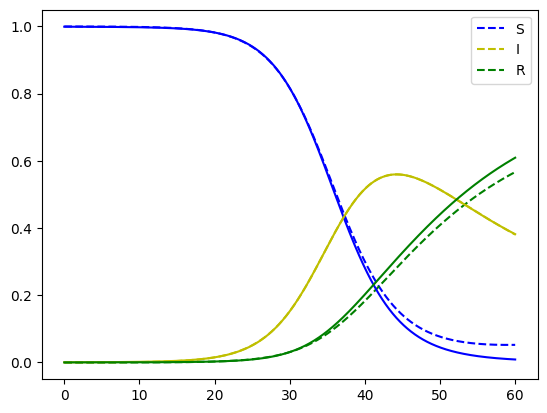

[Info]: Training 1000 epoch(s) on cpu using AdamW optimizer.


[CPU]: 100%|██████████| 1000/1000 [00:13<00:00, 75.67 epoch/s, bc_loss=1.75e-07, data_loss=1.14e-07, pde_loss=4.03e-08, loss=3.30e-07]


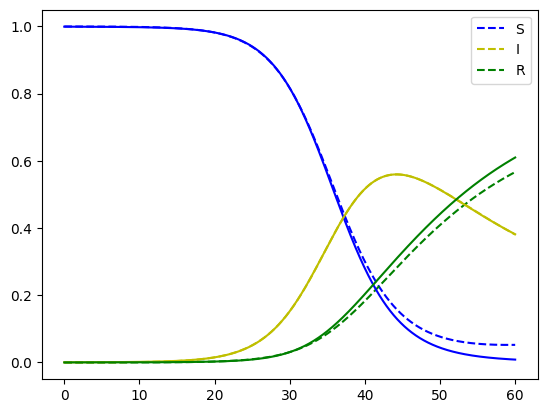

[Info]: Training 1000 epoch(s) on cpu using AdamW optimizer.


[CPU]: 100%|██████████| 1000/1000 [00:13<00:00, 75.57 epoch/s, bc_loss=1.32e-07, data_loss=1.12e-07, pde_loss=3.91e-08, loss=2.84e-07]


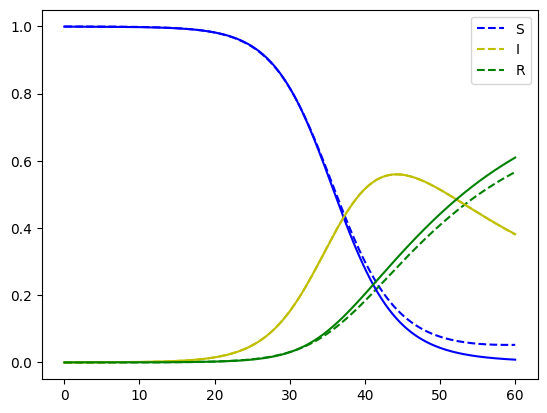

[Info]: Training 1000 epoch(s) on cpu using AdamW optimizer.


[CPU]:  13%|█▎        | 128/1000 [00:01<00:12, 69.41 epoch/s, bc_loss=1.28e-07, data_loss=9.79e-08, pde_loss=5.61e-08, loss=2.82e-07]


KeyboardInterrupt: 

In [560]:
for i in range(50):
    model.train_loop(1000, device='cpu')
    model.plot()

In [475]:
# model.save('sir_upinn_recycle_60_7data_0noise_33KAN', 'models')

In [ ]:
# name = 'sir_upinn_recycle_60_7data_norm_reg_shallow'
# model.save(name=name, path='models', overwrite=True)
# np.save('logs/'+name+'.npy', np.stack((model.log['loss'], model.log['bc_loss'], model.log['data_loss'], model.log['pde_loss']), axis=1))

[Info]: Successfully saved total model with name sir_upinn_recycle_60_7data_norm_reg_shallow at models


In [31]:
model.load('sir_upinn_recycle_60_7data_norm', 'models')

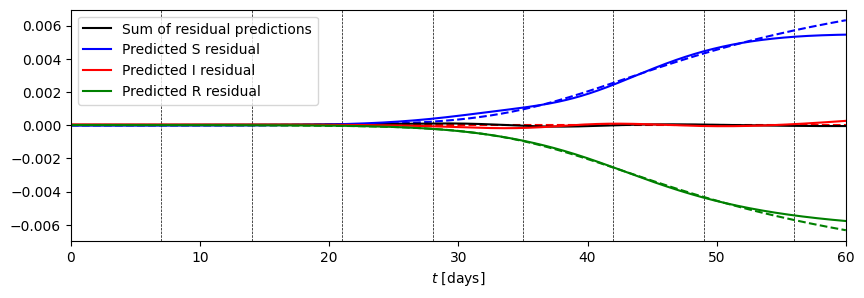

In [500]:
model.to('cpu')
u_pred = model.u(data.t_full)
S = u_pred[:,0].detach().numpy()
I = u_pred[:,1].detach().numpy()
R = u_pred[:,2].detach().numpy()
res_pred = -model.F(model.F_input(data.t_full, u_pred)).detach().numpy()

plt.figure( figsize=(10, 3))
for t in data.td:
    plt.axvline(t, color='black', linestyle='--', linewidth=0.5)
plt.plot(data.t_full, theta*R, color='blue', linestyle='--')
plt.plot(data.t_full, 0*R, color='red', linestyle='--')
plt.plot(data.t_full, -theta*R, color='green', linestyle='--')
plt.plot(data.t_full, res_pred[:,0]+res_pred[:,1]+res_pred[:,2], label='Sum of residual predictions', color='black')
plt.plot(data.t_full, res_pred[:,0], label='Predicted S residual', color='blue')
plt.plot(data.t_full, res_pred[:,1], label='Predicted I residual', color='red')
plt.plot(data.t_full, res_pred[:,2], label='Predicted R residual', color='green')
plt.xlim(data.t_full[0], data.t_full[-1])
plt.xlabel(r'$t$ [days]')
plt.legend()
# plt.savefig('gfx/sir_recycle_residuals_7_norm_reg_shallow.pdf', bbox_inches='tight', format='pdf')
plt.show()

# plt.figure( figsize=(10, 3))
# for t in data.td:
#     plt.axvline(t, color='black', linestyle='--', linewidth=0.5)
# plt.plot(data.t_full, -res_pred[:,0]+res_pred[:,2], label='Predicted S residual', color='blue')
# plt.plot(data.t_full, res_pred[:,0]-res_pred[:,1], label='Predicted I residual', color='red')
# plt.plot(data.t_full, -res_pred[:,2]+res_pred[:,1], label='Predicted R residual', color='green')
# plt.plot(data.t_full, theta*R, color='blue', linestyle='--')
# plt.plot(data.t_full, 0*R, color='red', linestyle='--')
# plt.plot(data.t_full, -theta*R, color='green', linestyle='--')
# plt.xlim(data.t_full[0], data.t_full[-1])
# plt.xlabel(r'$t$ [days]')
# plt.legend()
# plt.savefig('gfx/sir_recycle_residuals_7_norm_shared.pdf', bbox_inches='tight', format='pdf')
# plt.show()

#  res = torch.cat([-unknown[:, 0:1]+unknown[:, 2:3], unknown[:, 0:1]-unknown[:, 1:2], unknown[:, 1:2]-unknown[:, 2:3]], dim=-1)

In [1]:
res_exp = torch.cat([u_pred[:,2:3]*theta, 0*u_pred[:,1:2], -u_pred[:,2:3]*theta], dim=-1)

RRMSE_sol = torch.sqrt(torch.mean((u_pred - data.X_full)**2) / torch.mean(data.X_full**2))
RRMSE_res = torch.sqrt(torch.mean((torch.tensor(res_pred) - torch.tensor(res_exp))**2) / torch.mean(torch.tensor(res_exp)**2))
print(f"RRMSE: {RRMSE_sol:.10f}")
print(f"RRMSE res: {RRMSE_res:.10f}")

NameError: name 'torch' is not defined

In [504]:
model.collocation_points = sample_collocation_points(N_coll, 1, lb=[time_int[0]], ub=[100], method='grid').requires_grad_(True)

In [505]:
model.freeze_F()

In [167]:
data_long = CyclicSIRData(X0, beta, gamma, theta, [0, 100], N=1000, time_points=time_points, noise_level=0.0)

In [507]:
model.scheduler = None

In [506]:
model.optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [514]:
model.train_loop(10000, device='cpu')

[Info]: Training 10000 epoch(s) on cpu using AdamW optimizer.


[CPU]: 100%|██████████| 10000/10000 [02:07<00:00, 78.33 epoch/s, bc_loss=1.26e-08, data_loss=5.34e-09, pde_loss=2.64e-08, loss=4.44e-08]


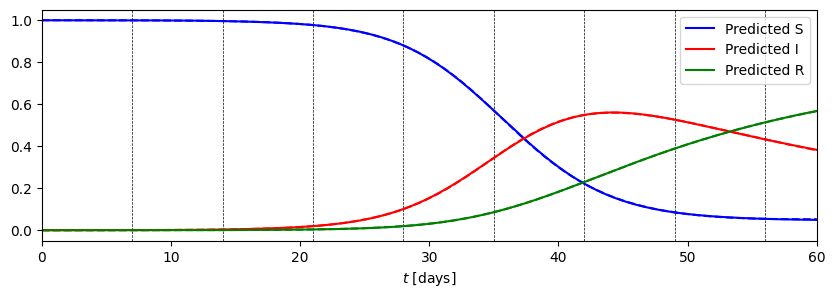

In [38]:
model.to('cpu')
u_pred = model.u(data.t_full)
S = u_pred[:,0].detach().numpy()
I = u_pred[:,1].detach().numpy()
R = u_pred[:,2].detach().numpy()

plt.figure( figsize=(10, 3))
for t in data.td:
    plt.axvline(t, color='black', linestyle='--', linewidth=0.5)
plt.plot(data.t_full, S, label='Predicted S', color='blue')
plt.plot(data.t_full, I, label='Predicted I', color='red')
plt.plot(data.t_full, R, label='Predicted R', color='green')
plt.plot(data.t_full, data.X_full[:, 0], color='blue', linestyle='--')
plt.plot(data.t_full, data.X_full[:, 1], color='red', linestyle='--')
plt.plot(data.t_full, data.X_full[:, 2], color='green', linestyle='--')
# plt.xlim(data.t_full[0], data.t_full[-1])
plt.xlim(data.t_full[0], data.t_full[-1])
plt.xlabel(r'$t$ [days]')
plt.legend()
plt.savefig('gfx/sir_recycle_solution.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import pysindy as ps

In [ ]:
# Generate data from the solution network
t = torch.linspace(0, 100, 100).reshape(-1, 1)
X = model.u(t)
X_dot = model.F(model.F_input(None, X))
t = t.detach().numpy()
X = X.detach().numpy()
X_dot = X_dot.detach().numpy()
# X_dot[:, 2] *= 0 # Recovered does not affect the dynamics

In [ ]:
# Hyperparameter tuning using Crossvalidation with TimeSeriesSplit
sindy_model = SINDy_sklearn(feature_names=['S', 'I', 'R'], feature_library=ps.PolynomialLibrary(degree=2), optimizer=ps.SR3(thresholder="L1", max_iter=1000000, normalize_columns=True))
paramgrid = dict(optimizer__threshold=np.linspace(0.0, 1.0, 100))

cv_folds = TimeSeriesSplit(n_splits=5)
model_selector = GridSearchCV(sindy_model, param_grid=paramgrid, cv=cv_folds, n_jobs=-1)
wrapped_input = np.concatenate([t, X], axis=1)
model_selector.fit(wrapped_input, X_dot)
best_model = model_selector.best_estimator_
best_model.print()

KeyboardInterrupt: 

In [ ]:
# Hyperparameter tuning using Crossvalidation with TimeSeriesSplit
sindy_model = SINDy_sklearn(feature_names=['S', 'I', 'R'], feature_library=ps.PolynomialLibrary(degree=2), optimizer=ps.SR3(thresholder="L1", max_iter=100, threshold=6.8, normalize_columns=True, fit_intercept=False))
sindy_model.fit(wrapped_input, X_dot)
sindy_model.print()

(S)' = 0.000
(I)' = 0.000
(R)' = 0.028 1 + -0.030 S


In [ ]:
best_model.optimizer.threshold

0.0

In [ ]:
np.linspace(0.0, 0.1, 100)

array([0.        , 0.0010101 , 0.0020202 , 0.0030303 , 0.0040404 ,
       0.00505051, 0.00606061, 0.00707071, 0.00808081, 0.00909091,
       0.01010101, 0.01111111, 0.01212121, 0.01313131, 0.01414141,
       0.01515152, 0.01616162, 0.01717172, 0.01818182, 0.01919192,
       0.02020202, 0.02121212, 0.02222222, 0.02323232, 0.02424242,
       0.02525253, 0.02626263, 0.02727273, 0.02828283, 0.02929293,
       0.03030303, 0.03131313, 0.03232323, 0.03333333, 0.03434343,
       0.03535354, 0.03636364, 0.03737374, 0.03838384, 0.03939394,
       0.04040404, 0.04141414, 0.04242424, 0.04343434, 0.04444444,
       0.04545455, 0.04646465, 0.04747475, 0.04848485, 0.04949495,
       0.05050505, 0.05151515, 0.05252525, 0.05353535, 0.05454545,
       0.05555556, 0.05656566, 0.05757576, 0.05858586, 0.05959596,
       0.06060606, 0.06161616, 0.06262626, 0.06363636, 0.06464646,
       0.06565657, 0.06666667, 0.06767677, 0.06868687, 0.06969697,
       0.07070707, 0.07171717, 0.07272727, 0.07373737, 0.07474